In [1]:
# In[1]:


import astropy.units as u
import numpy as np
from astropy.coordinates import SkyCoord, Distance
#import popsims
import matplotlib.pyplot as plt
from popsims.plot_style import  plot_style
from astropy.coordinates import SkyCoord
import astropy.coordinates as astro_coord
import astropy.units as u
from tqdm import tqdm
from popsims.galaxy import Disk, Halo, GalacticComponent
from popsims import sample_from_powerlaw
import popsims
from gala.units import UnitSystem
import pandas as pd
from scipy.interpolate import interp1d, griddata, InterpolatedUnivariateSpline
from astropy.io.votable import parse_single_table
import numba
plot_style()
import warnings
warnings.filterwarnings("ignore")
import glob
from tqdm import tqdm
#get_ipython().run_line_magic('matplotlib', 'inline')


# In[2]:
from popsims.plot_style import plot_style
plot_style()


path_isochrone='../data/isochrones/'
path_data='../data/images/'
path_streamdata='../data/stream/'
path_pipeline='../data/pipeline/'
path_pandas= '../data/pandas/'

In [2]:
#plt.style.use('dark_background') #for posters

In [3]:
rgc='10_20'
fname=path_isochrone+'/simulated_df_at_M31_normalized_extended_rgc{}.h5'.format(rgc)
df=pd.read_hdf(fname, key='data')

#put to the desired distance modulus 
mw_df= df.query("galaxy == 'MW'").reset_index(drop=True)
m31_df= df.query("galaxy =='M31'").reset_index(drop=True)

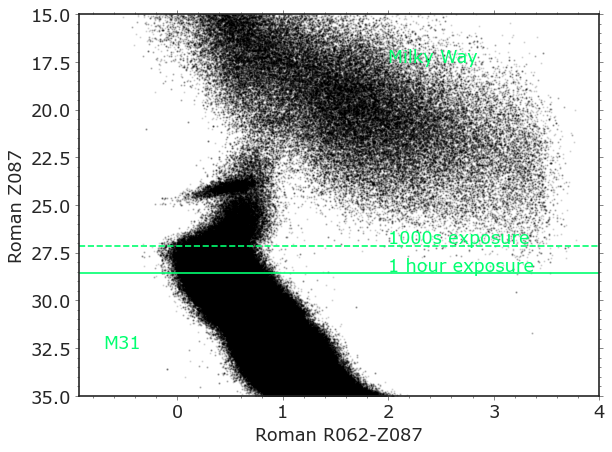

In [4]:
fig, ax=plt.subplots()

#ax.set(title='M31')
#ax.set(title='Milky Way')
p=ax.scatter(m31_df.appF062mag-m31_df.appF087mag, m31_df.appF087mag, s=1, alpha=0.1, c='k', label='M31 Halo')
ax.invert_yaxis()
ax.set(ylim=[35, 15])


ax.scatter(mw_df.appF062mag-mw_df.appF087mag, mw_df.appF087mag, s=1, alpha=0.1,  c='k', label='Milky Way')
#ax.invert_yaxis()
#ax[1].set(ylim=[35, 15])

#for a in ax:
ax.axhline(28.59, linestyle='-', c='#01FF70')
ax.axhline(27.15, linestyle='--', c='#01FF70')
ax.set(xlabel= 'Roman R062-Z087', ylabel='Roman Z087')

#plt.tight_layout()
#cax = fig.add_axes([0.08, 0., .3, 0.04])
#plt.colorbar(p, ax=ax, cax=cax, orientation='horizontal')
#cax.set(xlabel=r'[M/H]')
#ax.legend(markerscale=20)
#ax.text()
ax.text(-0.7, 32.5, "M31",c='#01FF70', fontsize=16)
ax.text(2, 17.5, "Milky Way",c='#01FF70', fontsize=16)

ax.text(2., 27.15-0.15, "1000s exposure",c='#01FF70', fontsize=16)
ax.text(2, 28.69-0.2, "1 hour exposure",c='#01FF70', fontsize=16)


ax.minorticks_on()
plt.tight_layout()
plt.savefig('../figures/simulated_CMD_Roman_M31.jpeg', bbox_inches='tight')

In [5]:
path_pandas= '/users/caganze/research/stellarstreams/data/pandas/'
data=parse_single_table(path_pandas+'M31_{}kpc_new.vot'.format(rgc)).to_table().to_pandas()
#data=(data[data.FeH_phot.values <0.5]).reset_index(drop=True) #remove metalpoor star


[Text(0.5, 0, 'g0-i0'), Text(0, 0.5, 'g0')]

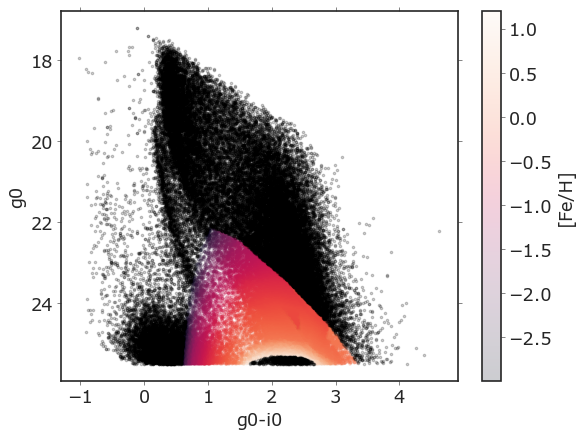

In [9]:
fig, ax=plt.subplots()
mask=data.FeH_phot >8
c=ax.scatter(data.g0[~mask]-data.i0[~mask], data.g0[~mask], c=data.FeH_phot[~mask], alpha=0.2, s=5)
ax.scatter(data.g0[mask]-data.i0[mask], data.g0[mask], c='k', alpha=0.2, s=5)
ax.invert_yaxis()
plt.colorbar(c, label='[Fe/H]')
ax.set(xlabel='g0-i0', ylabel='g0')


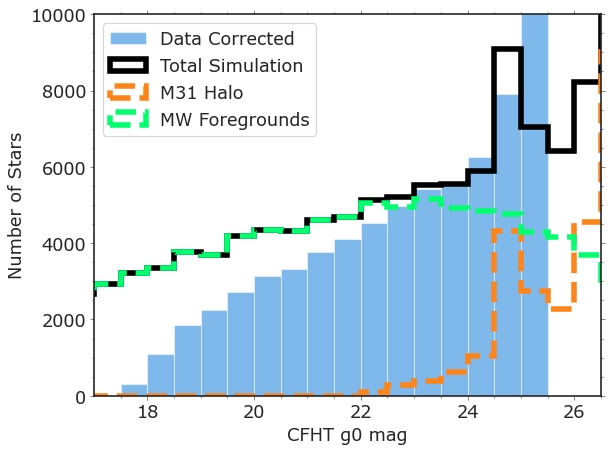

In [17]:
fig, ax=plt.subplots()
from astropy.io.votable import parse_single_table

_= plt.hist(data.g0, bins= np.arange(15, 27, 0.5), log=False, label='Data Corrected',alpha=0.5, color='#0074D9')
#_= plt.hist(data.g, bins= np.arange(15, 27, 0.5), log=False, label='Data',  hatch='/',alpha=0.2, color='#001f3f')
_= plt.hist(df.appgmag.values,
            bins= np.arange(15, 30, 0.5), log=False, histtype='step', linewidth=5, \
            label='Total Simulation', linestyle='-', color='k')
_= plt.hist(df.appgmag[df.galaxy.values == 'M31'].values,
            bins= np.arange(15, 30, 0.5), log=False, histtype='step',\
            linestyle='--', linewidth=5, label='M31 Halo', color='#FF851B')

_= plt.hist(df.appgmag[df.galaxy.values == 'MW'].values,
            bins= np.arange(15, 30, 0.5), log=False, histtype='step', linewidth=5, \
            label='MW Foregrounds', linestyle='--', color='#01FF70')


ax.set(xlabel='CFHT g0 mag', ylabel='Number of Stars', ylim=[0, 10_000], xlim=[17, 26.5])
ax.minorticks_on()
plt.legend()
plt.tight_layout()
plt.savefig('../figures/lf_check_rgc{}.jpeg'.format(rgc), bbox_inches='tight')

simulated_CMD_CFHT_rgc50_60.jpeg


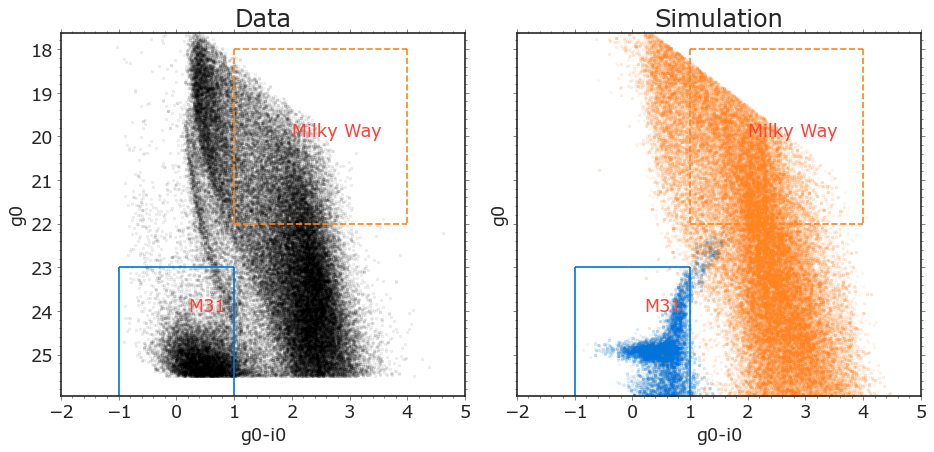

In [16]:
fig, ax=plt.subplots(ncols=2, figsize=(12, 6), sharey=True)

#ax[0].scatter(data.g-data.i, data.g, c='b', s=1, marker=',', alpha=0.05)
ax[0].scatter(data.g0-data.i0, data.g0, c='k', s=1, marker=',', alpha=0.05)
df0= df[np.logical_and.reduce([df.appgmag.values <data.g.max(), \
                       df.appgmag.values >data.g.min(),\
                        df.appimag.values >data.i.min(),\
                       df.appimag.values < data.i.max(),
                       (df.galaxy.values == 'M31')]) ]

df1= df[np.logical_and.reduce([df.appgmag.values <data.g.max(), \
                       df.appgmag.values >data.g.min(),\
                        df.appimag.values >data.i.min(),\
                       df.appimag.values < data.i.max(),
                       (df.galaxy.values == 'MW')]) ]
ax[1].scatter(df0.appgmag-df0.appimag, df0.appgmag, s=1, marker=',', alpha=0.05, label='M31',  color='#0074D9')
ax[1].scatter(df1.appgmag-df1.appimag, df1.appgmag, s=1, marker=',', alpha=0.05, label='MW', color='#FF851B')

#ax[1].vlines()
for a in ax:
    a.set(xlabel='g0-i0', ylabel='g0', xlim=[-2, 5])
    a.minorticks_on()
    
    a.hlines(23, xmin=-1., xmax=1., color='#0074D9')
    a.vlines(-1, ymin=23., ymax=26., color='#0074D9')
    a.vlines(1, ymin=23., ymax=26., color='#0074D9')
    
    
    a.hlines(22, xmin=1., xmax=4., color='#FF851B', linestyle='--')
    a.hlines(18, xmin=1., xmax=4., color='#FF851B', linestyle='--')
    a.vlines(1, ymin=18., ymax=22., color='#FF851B', linestyle='--')
    a.vlines(4, ymin=18., ymax=22.,color='#FF851B', linestyle='--')
    
    a.text(2., 20, "Milky Way",c='#FF4136', fontsize=16)
    a.text(0.2, 24, "M31",c='#FF4136', fontsize=16)
    a.set(ylim=[data.g.max(), data.g.min()])
    
#ax[-1].legend()
#ax[-1].legend(markerscale=20)
ax[-1].minorticks_on()
ax[0].set(title='Data')
ax[1].set(title='Simulation')

plt.tight_layout()
plt.savefig('../figures/simulated_CMD_CFHT_rgc{}.jpeg'.format(rgc),  bbox_inches='tight')
print('simulated_CMD_CFHT_rgc{}.jpeg'.format(rgc))

In [ ]:
#how about trying isochrones with no dust

In [ ]:
df.sample?

In [ ]:
ghj

In [ ]:
def count_densities(rgc):
    fname=path_isochrone+'/simulated_df_at_M31_normalized_extended_rgc{}.csv'.format(rgc)
    df=pd.read_csv(fname)
           
    df0=df[df.appF087mag<28.69]

    from astropy.io.votable import parse_single_table
    path_pandas= '/users/caganze/research/stellarstreams/data/pandas/'
    data=parse_single_table(path_pandas+'M31_{}kpc_new.vot'.format(rgc)).to_table().to_pandas()
    
    df1=df.query('appimag > {} & appimag< {}  & appgmag > {} & appgmag< {}'.format(*(data.i.min(), data.i.max(), data.g.min(), data.g.max())))
    
    print ('-----------------CFHT data-------------')
    print ((len(data)/2.8)/1e4)
    
    print ('-----------------CFHT simulated---------')
    print ((len(df1)/2.8)/1e4)
    
    print ('------------------Roman------------------------')
    print ((len(df0)/2.8)/1e4)

In [ ]:
from popsims import sample_from_powerlaw
import scipy.interpolate as interp
path_isochrone='../data/isochrones/'
isochrone_path=path_isochrone
mag_keys=['gmag', 'imag', 'F062mag', 'F087mag']
from scipy.interpolate import interp1d, griddata
from tqdm import tqdm


def count_pal5_stars_old(mag_limit, dmod):
        dmod_pal5=16.85
        cfht_mini = np.loadtxt(isochrone_path+'/Isochrone_CFHT_PARSEC_withDust_newZ.txt', skiprows = 8, usecols = [2])
        cfht_gmag = np.loadtxt(isochrone_path+'/Isochrone_CFHT_PARSEC_withDust_newZ.txt', skiprows = 8, usecols = [24])
        cfht_imag = np.loadtxt(isochrone_path+'/Isochrone_CFHT_PARSEC_withDust_newZ.txt', skiprows = 8, usecols = [25])
        wfirst_mini = np.loadtxt(isochrone_path+'/Isochrone_WFIRST_PARSEC_withDust_newZ.txt', skiprows = 8, usecols = [2])
        wfirst_mags = np.loadtxt(isochrone_path+'/Isochrone_WFIRST_PARSEC_withDust_newZ.txt', skiprows = 8, usecols = [23,24,25,26,27,28,29])

        sample_lowmasses=sample_from_powerlaw(-0.5, xmin=np.min(cfht_mini), xmax=np.max(cfht_mini), nsample=int(1e6)) 
        inter_gmags = interp.interp1d(cfht_mini, cfht_gmag, bounds_error=False,  fill_value=np.nan)
        inter_imags = interp.interp1d(cfht_mini, cfht_imag, bounds_error=False,  fill_value=np.nan)
        inter_Rmags = interp.interp1d(wfirst_mini, wfirst_mags[:,0], bounds_error=False,  fill_value=np.nan)
        inter_Zmags = interp.interp1d(wfirst_mini, wfirst_mags[:,1], bounds_error=False,  fill_value=np.nan)
        inter_Ymags = interp.interp1d(wfirst_mini, wfirst_mags[:,2], bounds_error=False,  fill_value=np.nan)
        inter_Jmags = interp.interp1d(wfirst_mini, wfirst_mags[:,3], bounds_error=False,  fill_value=np.nan)
        inter_Hmags = interp.interp1d(wfirst_mini, wfirst_mags[:,4], bounds_error=False,  fill_value=np.nan)
        inter_Fmags = interp.interp1d(wfirst_mini, wfirst_mags[:,5], bounds_error=False,  fill_value=np.nan)
        inter_Wmags = interp.interp1d(wfirst_mini, wfirst_mags[:,6], bounds_error=False,  fill_value=np.nan)

        if np.sum(sample_lowmasses < np.min(cfht_mini)) > 0 or np.sum(sample_lowmasses > np.max(cfht_mini)) > 0:
            print("outside of interpolation range based on the CFHT-parsec SSP file. Need to resolve this.")
        else:    
            #CFHT magnitudes
            sample_gmags = inter_gmags(sample_lowmasses) +  dmod_pal5  #distance modulus Pal5
            sample_imags = inter_imags(sample_lowmasses) +  dmod_pal5 #distance modulus Pal5
            #WFIRST magnitudes
            sample_Rmags = inter_Rmags(sample_lowmasses) +  dmod_pal5  #distance modulus Pal5
            sample_Zmags = inter_Zmags(sample_lowmasses)+  dmod_pal5 #distance modulus Pal5
            sample_Ymags = inter_Ymags(sample_lowmasses)  +  dmod_pal5 
            sample_Jmags = inter_Jmags(sample_lowmasses)+  dmod_pal5  #distance modulus Pal5
            sample_Hmags = inter_Hmags(sample_lowmasses) +  dmod_pal5 #distance modulus Pal5
            sample_Fmags = inter_Fmags(sample_lowmasses)+  dmod_pal5 #distance modulus Pal5
            sample_Wmags = inter_Wmags(sample_lowmasses) +  dmod_pal5 #distance modulus Pal5

            #renormalize the luminosity function by computing a normalization factor
            num_20_23= len(sample_gmags[np.logical_and(sample_gmags>=20, sample_gmags<=23)])
            #print ('number of stars between 20 and 23 G mag {}'.format( num_20_23))

            norm= 3000/num_20_23
            #print (norm)

            #compute the difference between distance moduli and offset stars
            dist_mod_And = dmod-dmod_pal5
            #offset_Zmags= sample_Zmags+  dist_mod_And
            nstars_wfirst = (len(np.where((sample_Zmags < (mag_limit-dist_mod_And)  ))[0]))*norm

            #fig, ax=plt.subplots()
            #plt.scatter( sample_lowmasses, sample_gmags)
            #ax.set(ylabel=k, xlabel='Mass ')
            #j
            return nstars_wfirst

In [ ]:
def read_backgrounds_file(m, rgc):
    
    fls= glob.glob('../data/backgrounds/*rgc{}*maglimit{}*'.format(rgc, m))
    
    res=[]
    for f in fls:
        #print (f)
        c=np.load(f, allow_pickle=True)
        for vls in c:
            #print (vls)
            dct={}
            for k in list(vls.keys()):
                dct['dmod']=float(k.split('galaxy')[-1])
                dct['run']=f.split('run')[-1].split('.npy')[0]
                for ks in (vls[k].keys()):
                    dct[ks]=vls[k][ks]
                    
                data= vls[k]['data']
                area= (data[0].max()-data[0].min())*(data[1].max()-data[1].min())
                dct['density']= len(data[0])/area
                dct['area']=area
                dct['counts']=len(data[0])
                #stream_mask= np.logical_and(np.abs(data[0]-np.nanmedian(data[0]))<4.5 , np.abs(data[1]-np.nanmedian(data[1]))<0.05)
                dct['counts_in_5kpc']= len(data[0])*((0.973)/area)
                res.append(dct)
               
    
    return pd.DataFrame(res)


In [ ]:
bckd=read_backgrounds_file(28.69, '30_40')
bckd['distance']=10**((bckd.dmod.values/5)+1)

In [ ]:
#bckd

In [ ]:


def resample_image(row, plot=False, iterations=100):
    
    rs=[]
    for i in range(0, int(iterations)):
        try:
            data=row.data
            mask=np.logical_and(np.abs(data[0]-data[0].mean()) <np.random.uniform(2, 5),
                                  (np.abs(data[1]-data[1].mean()) <np.random.uniform(2, 5)))
            small=[data[0][mask], data[1][mask]]
            if plot:
                fig, ax=plt.subplots()
                ax.scatter(data[0], data[1], s=.1, marker='.')
                ax.scatter(small[0], small[1], s=.1, marker='.')

                #ax[1].hist(data[1], bins=32, log=True)
                #ax[1].hist(small[1], bins=32, log=True)

                plt.tight_layout()


            new_dens=len(small[0])/(np.ptp(small[0])*np.ptp(small[1]))
            old_dens=len(data[0])/(np.ptp(data[0])*np.ptp(data[1]))


            rs.append(new_dens/old_dens)
        except:
            pass
    return np.nanmedian(rs)
    

In [ ]:
bckd.apply(resample_image, axis=1)

In [ ]:

#for idx in range(0, 50):
ratios=bckd.apply(resample_image, axis=1)
#ratios=pd.concat(rs)

bckd['new_ratios']=ratios

In [ ]:
med_rs=[]
dgrid=np.arange(0.5, 10, 0.15)
for idx in range(len(dgrid)-1):
        v=bckd[np.logical_and(bckd.distance/1e6>=dgrid[idx], bckd.distance/1e6<dgrid[idx+1])]
        med_rs.append(np.nanmedian(v.new_ratios))
        

In [ ]:
fig, ax=plt.subplots()
ax.scatter( bckd.distance/1e6, ratios)
ax.plot(dgrid[:-1], med_rs, linewidth=3, color='k')
ax.axhline(1, linestyle='--',color='k')
_ =ax.set(xlabel='distance (Mpc)', xscale='log',  xticks=[1, 2, 3, 4, 5, 7, 10],xticklabels=[1, 2, 3, 4, 5, 7, 10], ylabel='Ratio (random patch/ full FOV)')

In [ ]:
#number of stars in the stream? can make this realstic
0.09/2

In [ ]:

def resample_image_with_fake_stream(row, plot=False, iterations=1):
    
    rs=[]
    for i in range(0, int(iterations)):
        data=row.data
        
        
        n= count_pal5_stars_old(28.69, float(row.dmod))
        
        stream= [np.random.uniform(np.nanmedian(row.data[0])-5, np.nanmedian(row.data[0])+5, int(n)),
                np.random.uniform(np.nanmedian(row.data[1])-0.05, np.nanmedian(row.data[1])+0.05, int(n))]
        
        if plot:
            fig, ax=plt.subplots()
            ax.scatter(data[0], data[1], s=100, marker='.',  c='k', alpha=0.1)
            ax.scatter(stream[0], stream[1], s=100, marker='.', c='k', alpha=0.1)
            
            ax.set(xlim=[np.nanmedian(row.data[0])-2.5, np.nanmedian(row.data[0])+2.5],
                   ylim=[np.nanmedian(row.data[0])-1, np.nanmedian(row.data[0])+1])

            plt.tight_layout()


        new_dens=len(stream[0])/(5*0.1)
        old_dens=len(data[0])/(np.ptp(data[0])*np.ptp(data[1]))


        rs.append(new_dens/old_dens)
    return np.nanmedian(rs)
    

In [ ]:
resample_image_with_fake_stream(bckd.iloc[0], plot=True, iterations=1)

In [ ]:
bckd.distance.iloc[-80]/1e6

In [ ]:
resample_image_with_fake_stream(bckd.iloc[-80], plot=True, iterations=1)

In [ ]:
ratios=bckd.apply(resample_image_with_fake_stream, axis=1)
bckd['new_ratios_stream']=ratios

In [ ]:
med_rs_st=[]
dgrid=np.arange(0.5, 10, 0.15)
for idx in range(len(dgrid)-1):
        v=bckd[np.logical_and(bckd.distance/1e6>=dgrid[idx], bckd.distance/1e6<dgrid[idx+1])]
        med_rs_st.append(np.nanmedian(v.new_ratios_stream))

In [ ]:
fig, ax=plt.subplots()
ax.scatter( bckd.distance/1e6, ratios)
ax.plot(dgrid[:-1], med_rs_st, linewidth=3, color='k')
ax.axhline(1, linestyle='--',color='k')
_ =ax.set(xlabel='distance (Mpc)', xscale='log',  xticks=[1, 2, 3, 4, 5, 7, 10],xticklabels=[1, 2, 3, 4, 5, 7, 10], ylabel='Ratio (stream/backgrounds)')

In [ ]:
from astropy.io.votable import parse_single_table
data_with_coords=parse_single_table(path_pandas+'M31_{}kpc_new.vot'.format(rgc)).to_table().to_pandas()
    

In [ ]:
def count_m31_stars(df, d_galaxy, mag_limit, rgc):
    d_m31= 770*u.kpc
    dmod_m31=5*np.log10(d_m31.to(u.pc).value/10.0)

    
    dmod_galaxy=5*np.log10(d_galaxy.to(u.pc).value/10.0)
    dmod_diff= dmod_galaxy-dmod_m31
    kpc_conversion = np.pi * d_galaxy / 180.
    
    #put to the desired distance modulus 
    mw_df= df[df.galaxy == 'MW'].reset_index(drop=True)
    m31_df= df[df.galaxy =='M31'].reset_index(drop=True)
    
    for k in ['appF062mag', 'appF087mag', 'appgmag', 'appimag']:
         m31_df[k]=  m31_df[k].values+dmod_diff
            
    #appply magnitude cut
    df_final=pd.concat([m31_df, mw_df]).reset_index(drop=True)
    df_final=(df_final[df_final.appF087mag < mag_limit]).reset_index(drop=True)
    
    
    
    for k in ['RA', 'Dec','xki', 'eta']:
        df_final[k]=np.random.choice(data_with_coords[k].values, len(df_final), replace=True)
              
    s=SkyCoord(ra=df_final.RA, dec=df_final.Dec,frame = 'icrs', unit = (u.hourangle, u.deg))
    
    center=np.nanmedian(np.array(rgc.split('_')).astype(float))
              
    shift_x=np.nanmedian(kpc_conversion.value*(s.ra.to(u.degree).value))-center
    shift_y=np.nanmedian(kpc_conversion.value*(s.dec.to(u.degree).value))-center
    
    df_final['x_coord']=kpc_conversion.value*(s.ra.to(u.degree).value)-shift_x
    df_final['y_coord']=kpc_conversion.value*(s.dec.to(u.degree).value)-shift_y
    
    
    z= df_final.appF087mag.values
    r= df_final.appF062mag.values
    n= len(df_final)
    
    folder= '../data/mockbackgrounds/'
    filename='rgc{}dmod{:.2f}mlimit{:.2f}'.format(rgc, dmod_galaxy, mag_limit)
    df_final.to_csv(folder+filename)
    return [z, r, n]
    

In [ ]:
#rgc

In [ ]:
#hgjk

In [ ]:
fname=path_isochrone+'/simulated_df_at_M31_normalized_extended_rgc{}.csv'.format(rgc)
df=pd.read_csv(fname)

In [ ]:
ds=np.arange(500, 10000, 100)*u.kpc

In [ ]:
ns=[count_m31_stars(df,x, 27.15, rgc) for x in tqdm(ds)]

In [ ]:
ns=np.array(ns)

In [ ]:
 n= [count_pal5_stars_old(28.69, float(x)) for x in bckd.dmod.values]

In [ ]:
#

In [ ]:
#n_areas=[x[]]

In [ ]:
fig, ax=plt.subplots()
plt.scatter(10**((bckd.dmod.values/5)+1)/1e6, np.log10(np.array(n))+3, label='Log N Stream +3 ')
plt.scatter( ds.to(u.pc)/1e6, np.log10(np.array(ns[:,-1]).astype(float)), label='Log N Backgrounds')
plt.legend()
_ = ax.set(xlabel='distance (Mpc)', xscale='log',  xticks=[1, 2, 3, 4, 5, 7, 10],xticklabels=[1, 2, 3, 4, 5, 7, 10], ylabel='Log Number of Stars + Offset')

In [ ]:
#y0=np.interp(dgrid, (bckd.distance/1e6).values, (bckd.counts_in_5kpc).values)
y_bck=np.interp(dgrid, (bckd.distance/1e6).values, (bckd.counts_in_5kpc).values)
y_st= np.interp(dgrid, 10**((bckd.dmod.values/5)+1)/1e6, np.array(n))

In [ ]:
fig, ax=plt.subplots()

ax.plot(dgrid, y_bck, label=r'Backgrounds in 0.9 kpc$^2$', linewidth=3, color='k', linestyle='--')

ax.scatter(10**((bckd.dmod.values/5)+1)/1e6,  np.array(n), color='k')
ax.plot(dgrid, y_st,  label='Pal 5', linewidth=4, color='k')

ax.plot(dgrid,70*np.sqrt(y_bck), linestyle= '--', linewidth=3, label=' 70 x Sqrt(N background)')
ax.plot(dgrid,50*np.sqrt(y_bck), linestyle= '--', linewidth=3, label=' 50 x Sqrt(N background)')
ax.plot(dgrid,15*np.sqrt(y_bck), linestyle= '--', linewidth=3, label=' 15 x Sqrt(N background)')
#ax.plot(dgrid, 15*(y_st/((np.sqrt(y_bck)**2+np.sqrt(y_st)**2)**0.5)), linestyle= ':', linewidth=3, \
#        label=r'15 x (Nst/(SQRT(Nbck)$^2$+SQRT(Nst)$^2$)$^{0.5}$')


plt.tight_layout()
#for a in ax:
ax.set( xscale='log')

plt.tight_layout()
ax.axvline(0.77, color='k', linewidth=3, alpha=0.5)
ax.text(0.8, 10**5, 'M31')
ax.axvline(0.049, color='k', linewidth=3, alpha=0.5)
ax.text(0.05, 10**5, 'LMC')
ax.legend(loc='lower left')
ax.axvline(6.4, color='k', linewidth=3, alpha=0.5)
ax.text(6.45, 10**5, 'M101')
_ = ax.set(yscale='log', xlim=[0.01, 20], ylim=[1, 2e5], ylabel='Number of Resolved Stars', xlabel='Distance (Mpc)', xscale='log',  xticks=[1, 2, 3, 4, 5, 7, 10],xticklabels=[1, 2, 3, 4, 5, 7, 10])

In [ ]:
0.049*1000


In [ ]:
ds.to(u.Mpc).value

In [ ]:

for idx in range(len(ns)):
    x= ns[idx]
    d=ds[idx]
    fig, ax=plt.subplots(figsize=(8*0.6, 6*0.6))
    ax.scatter(x[1]-x[0], x[0], s=.1, alpha=0.1)
    ax.invert_yaxis()
    ax.set(xlabel='R-Z', ylabel='z', title='Distance= {:.2f} Mpc'.format(d.to(u.Mpc).value))

In [ ]:
ns[0]

In [ ]:
70/15